<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [150]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [151]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-04 18:11:58--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22,56K   110KB/s    in 0,2s    

2020-08-04 18:11:59 (110 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [152]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [153]:
df.shape

(346, 10)

### Convert to date time object 

In [154]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [155]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [156]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

/usr/bin/sh: 1: conda: not found


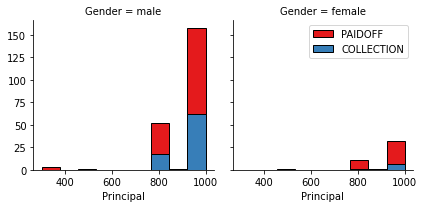

In [157]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

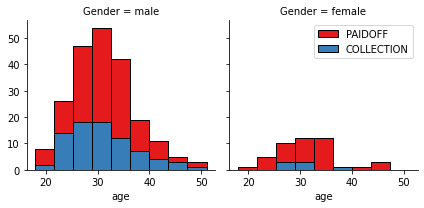

In [158]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

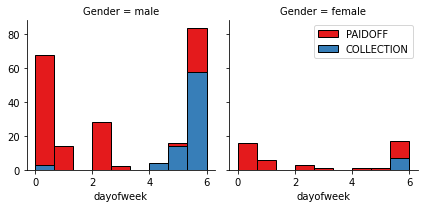

In [159]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [160]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [161]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [162]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [163]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [164]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [165]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [166]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [167]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [168]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=4)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
print('X_train',X_train[0:5])
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
print('X_test',X_test[0:5])

X_train (276, 8)
X_test (70, 8)
y_train (276,)
y_test (70,)
X_train [[ 0.56081126 -0.9677917   0.69858179 -0.40565621 -1.17444044 -0.40565621
  -0.90321065  1.21007674]
 [ 0.56081126  0.9437816  -0.81959596 -0.40565621  0.85146932 -0.40565621
   1.10716144 -0.82639387]
 [ 0.56081126  0.9437816   0.02383612 -0.40565621 -1.17444044 -0.40565621
  -0.90321065  1.21007674]
 [ 0.56081126 -0.9677917  -0.98828237 -0.40565621  0.85146932 -0.40565621
  -0.90321065  1.21007674]
 [ 0.56081126  0.9437816  -0.48222312 -0.40565621 -1.17444044 -0.40565621
  -0.90321065  1.21007674]]
X_test [[ 0.33474248  0.83916906 -0.19614926 -0.47756693  0.74535599 -0.2773501
   1.26197963 -1.05887304]
 [-1.70282047 -0.9301633  -0.19614926 -0.47756693  0.74535599 -0.2773501
  -0.79240582  0.94440028]
 [ 0.33474248 -0.9301633  -0.04012144 -0.47756693 -1.34164079 -0.2773501
   1.26197963 -1.05887304]
 [ 0.33474248  0.83916906 -1.13231619 -0.47756693 -1.34164079 -0.2773501
  -0.79240582  0.94440028]
 [ 0.33474248  0.83

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

Jaccard Similarity Score - Accuracy using k= 1 :  0.6714285714285714
Jaccard Similarity Score - Accuracy using k= 2 :  0.6428571428571429
Jaccard Similarity Score - Accuracy using k= 3 :  0.7285714285714285
Jaccard Similarity Score - Accuracy using k= 4 :  0.6571428571428571
Jaccard Similarity Score - Accuracy using k= 5 :  0.7142857142857143
Jaccard Similarity Score - Accuracy using k= 6 :  0.6571428571428571
Jaccard Similarity Score - Accuracy using k= 7 :  0.7428571428571429
Jaccard Similarity Score - Accuracy using k= 8 :  0.7428571428571429
Jaccard Similarity Score - Accuracy using k= 9 :  0.7142857142857143


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  warnings.warn('jaccard_similarity_score has been deprecated and replaced '
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  warnings.warn('jaccard_similarity_score has been deprecated and replaced '
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising beh

Text(0, 0.5, 'Accuracy')

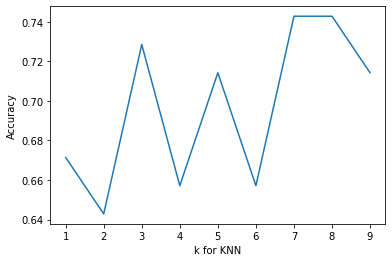

In [169]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_similarity_score

k_range = range(1,10)
accuracy_score = []
for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean').fit(X_train,y_train)
    KNN_yhat = KNN.predict(X_test)
    print('Jaccard Similarity Score - Accuracy using k=', k , ': ' , jaccard_similarity_score(y_test, KNN_yhat))
    accuracy_score.append(jaccard_similarity_score(y_test, KNN_yhat))

plt.plot(k_range,accuracy_score)
plt.xlabel('k for KNN')
plt.ylabel('Accuracy')



In [170]:
KNN = KNeighborsClassifier(n_neighbors = 7, metric = 'euclidean').fit(X_train, y_train)
KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

# Decision Tree

In [171]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

In [172]:
depth_range = range(3,8)
f1 = []
jaccard = []

for d in depth_range:
    DECTREE = DecisionTreeClassifier(criterion='entropy',max_depth=d)
    DECTREE.fit(X_train,y_train)
    DECTREE_yhat = DECTREE.predict(X_test)
    f1.append(f1_score(y_test,DECTREE_yhat,average='weighted'))
    jaccard.append(jaccard_similarity_score(y_test,DECTREE_yhat))
    
result = pd.DataFrame(f1, index=['d=3','d=4','d=5','d=6','d=7'])
result.columns = ['f1-score']
result.insert(loc=1, column='Jaccard', value=jaccard)
result.columns.name = 'Tree Depth'
result

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  warnings.warn('jaccard_similarity_score has been deprecated and replaced '
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  warnings.warn('jaccard_similarity_score has been deprecated and replaced '
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising beh

Tree Depth,f1-score,Jaccard
d=3,0.620577,0.585714
d=4,0.620577,0.585714
d=5,0.648789,0.614286
d=6,0.706479,0.771429
d=7,0.697881,0.757143


In [173]:
DECTREE = DecisionTreeClassifier(criterion='entropy',max_depth=6)

DECTREE.fit(X_train,y_train)
DECTREE

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Support Vector Machine

In [174]:
from sklearn import svm
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline

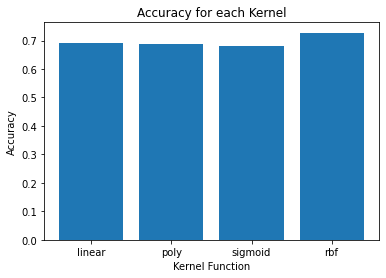

0.7275882012724117


In [175]:
func_list = ['linear','poly','sigmoid','rbf']
accuracy_score = []

for function in func_list:
    SVM = svm.SVC(kernel=function)
    SVM.fit(X_train,y_train)
    SVM_yhat = SVM.predict(X_test)
    accuracy_score.append(f1_score(y_test,SVM_yhat,average='weighted'))
    
y_pos = np.arange(len(func_list))
plt.bar(y_pos, accuracy_score)
plt.xticks(y_pos, func_list)
plt.xlabel('Kernel Function')
plt.ylabel('Accuracy')
plt.title('Accuracy for each Kernel')
plt.show()

print(max(accuracy_score))

In [184]:
from sklearn import svm

SVM = svm.SVC(kernel='rbf')
SVM.fit(X_train,y_train)
SVM

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Logistic Regression

Test number: 0 -> Accuracy at c_value =  0.1 using solver= liblinear is :  0.4909656081845792
Test number: 1 -> Accuracy at c_value =  0.1 using solver= newton-cg is :  0.477460130698766
Test number: 2 -> Accuracy at c_value =  0.1 using solver= lbfgs is :  0.4774602624038005
Test number: 3 -> Accuracy at c_value =  0.1 using solver= sag is :  0.4774590606263958
Test number: 4 -> Accuracy at c_value =  0.1 using solver= saga is :  0.4774625300950357
Test number: 5 -> Accuracy at c_value =  0.01 using solver= liblinear is :  0.5699980927778155
Test number: 6 -> Accuracy at c_value =  0.01 using solver= newton-cg is :  0.4893356417828644
Test number: 7 -> Accuracy at c_value =  0.01 using solver= lbfgs is :  0.48933560490693945
Test number: 8 -> Accuracy at c_value =  0.01 using solver= sag is :  0.489332137349164
Test number: 9 -> Accuracy at c_value =  0.01 using solver= saga is :  0.4893355484401967
Test number: 10 -> Accuracy at c_value =  0.001 using solver= liblinear is :  0.669110

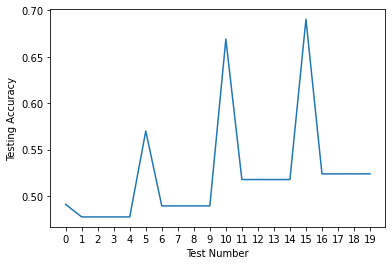

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline

c_list = [0.1, 0.01, 0.001, 0.0001]
solver_list = ['liblinear','newton-cg','lbfgs','sag','saga']

accuracy_score = []

test_number = []

for c_list_pos, c in enumerate(c_list):
    for solver_list_pos, sol in enumerate(solver_list):
        test_number.append(solver_list_pos + c_list_pos * 5)
        LR = LogisticRegression(C=c, solver=sol).fit(X_train,y_train)
        LR_yhat = LR.predict(X_test)
        LR_prob = LR.predict_proba(X_test)
        print('Test number:',solver_list_pos + c_list_pos * 5,'-> Accuracy at c_value = ', c, 'using solver=', sol, 'is : ', log_loss(y_test,LR_prob))
        accuracy_score.append(log_loss(y_test, LR_prob))
        
LR_prob = LR.predict_proba(X_test)
log_loss(y_test, LR_prob)

plt.plot(test_number, accuracy_score)
plt.xticks(np.arange(min(test_number), max(test_number)+1, 1.0))
plt.xlabel('Test Number')
plt.ylabel('Testing Accuracy')

print('Test number with highest accuracy score:',accuracy_score.index(max(accuracy_score)))
print('Value of maximum accuracy score:',max(accuracy_score))


In [178]:
LR = LogisticRegression(C=0.0001, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

# Model Evaluation using Test set

In [179]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [180]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-04 18:12:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3,6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3,56K  --.-KB/s    in 0s      

2020-08-04 18:12:06 (511 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [196]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [197]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_features = test_df[['Principal','terms','age','Gender','weekend']]
test_features = pd.concat([test_features,pd.get_dummies(test_df['education'])], axis=1)
test_features.drop(['Master or Above'], axis = 1,inplace=True)

X_testdataset = test_features

X_testdataset = preprocessing.StandardScaler().fit(X_testdataset).transform(X_testdataset)

y_testdataset = test_df['loan_status'].values

print(X_testdataset)
print(y_testdataset)

print(test_df.head())

[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]
 [-1.24479571 -0.78854628  0.19650211 -0.50578054  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588 -0.78854628 -1.31937134 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [ 0.49362588  0.92844966  0.02807173 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]
 [-0.66532184 -0.78854628 -0.81408019  1.97714211  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [ 0.49362588 -0.78854628  0.87022365 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.

In [198]:
jaccard_values = []

KNN_yhat = KNN.predict(X_testdataset)
jaccard1 = jaccard_similarity_score(y_testdataset,KNN_yhat)

DECTREE_yhat = DECTREE.predict(X_testdataset)
jaccard2 = jaccard_similarity_score(y_testdataset, DECTREE_yhat)

SVM_yhat = SVM.predict(X_testdataset)
jaccard3 = jaccard_similarity_score(y_testdataset, SVM_yhat)

LR_yhat = LR.predict(X_testdataset)
jaccard4 = jaccard_similarity_score(y_testdataset, LR_yhat)

jaccard_values = [jaccard1,jaccard2,jaccard3,jaccard4]
print(jaccard_values)

f1score_values = []

f1score_1 = f1_score(y_testdataset,KNN_yhat,average='weighted')

f1score_2 = f1_score(y_testdataset, DECTREE_yhat,average='weighted')

f1score_3 = f1_score(y_testdataset, SVM_yhat,average='weighted')

f1score_4 = f1_score(y_testdataset, LR_yhat,average='weighted')

f1score_values = [f1score_1,f1score_2,f1score_3,f1score_4]
print(f1score_values)

log_loss_values = []

LR_prob = LR.predict_log_proba(X_testdataset)

log_loss_values = ['NA','NA','NA',log_loss(y_testdataset,LR_prob)]

print(log_loss_values)

[0.6666666666666666, 0.7037037037037037, 0.7962962962962963, 0.7592592592592593]
[0.6328400281888654, 0.6378600823045267, 0.7583503077293734, 0.7144140000438048]
['NA', 'NA', 'NA', 0.6931471805599455]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  warnings.warn('jaccard_similarity_score has been deprecated and replaced '
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  warnings.warn('jaccard_similarity_score has been deprecated and replaced '
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising beh

In [209]:
final_report_table = pd.DataFrame(jaccard_values, index=['KNN','Decision Tree','SVM','LogisticRegression'])
#print(final_report_table)
final_report_table.columns = ['Jaccard']
final_report_table.insert(loc=1, column='F1-score',value=f1score_values)
final_report_table.insert(loc=2, column='LogLoss',value=log_loss_values)

final_report_table.columns.name = 'Algorithm'

final_report_table


Algorithm,Jaccard,F1-score,LogLoss
KNN,0.666667,0.632840,NA
Decision Tree,0.703704,0.637860,NA
SVM,0.796296,0.758350,NA
LogisticRegression,0.759259,0.714414,0.693147


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>